--------
- # 요약
    - 3-5-1, 3-5-2 참조
--------

# 내용


## 데이터 입력
- 문자열 데이터의 원-핫 벡터 구조
- RNN 의 입력 데이터 형태 체크
- RNN 에 인풋데이터 입력하면 seq_length 는 알아서 계산해서 사용함


In [27]:
import torch
import numpy as np

In [28]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [29]:
# declare dimension
input_size = 4
hidden_size = 2

In [30]:
# singleton example
# shape : (1, 1, 4)
# input_data_np = np.array([[[1, 0, 0, 0]]])

# sequential example
# shape : (3, 5, 4)
h = [1, 0, 0, 0]
e = [0, 1, 0, 0]
l = [0, 0, 1, 0]
o = [0, 0, 0, 1]
input_data_np = np.array([[h, e, l, l, o], [e, o, l, l, l], [l, l, e, e, l]], dtype=np.float32)

In [31]:
# transform as torch tensor
input_data = torch.Tensor(input_data_np)

In [32]:
# declare RNN
rnn = torch.nn.RNN(input_size, hidden_size)

In [33]:
# check output
outputs, _status = rnn(input_data)
print(outputs)
print(outputs.size())

tensor([[[-0.7497, -0.6135],
         [-0.5282, -0.2473],
         [-0.9136, -0.4269],
         [-0.9136, -0.4269],
         [-0.9028,  0.1180]],

        [[-0.5753, -0.0070],
         [-0.9052,  0.2597],
         [-0.9173, -0.1989],
         [-0.9173, -0.1989],
         [-0.8996, -0.2725]],

        [[-0.9077, -0.3205],
         [-0.8944, -0.2902],
         [-0.5134, -0.0288],
         [-0.5134, -0.0288],
         [-0.9127, -0.2222]]], grad_fn=<StackBackward0>)
torch.Size([3, 5, 2])


## 기본 훈련
- 리스트 컴프리핸션 이용한 원-핫 벡터 생성
- np.eye
    - 주 대각선의 원소 값이 1인 항등행렬 생성
    - 원-핫 벡터 생성용임
- 마지막 입력 원소는 예측에 사용되지 않고, 예측의 첫 원소 $y_0$ 은 임의로 설정되기 때문에 사용되지 않음
- 손실함수 계산시 텐서의 형태가 조금 다르니 확인할것
- _status 는 현재 시점의 은닉 상태임. 장기기억이라 생각할것


In [34]:
import torch
import torch.optim as optim
import numpy as np

In [35]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [36]:
sample = " if you want you"

In [37]:
# make dictionary
char_set = list(set(sample))
print(char_set)
char_dic = {c: i for i, c in enumerate(char_set)}
print(char_dic)

['y', 'w', 'f', 'a', 'i', 't', 'u', 'n', 'o', ' ']
{'y': 0, 'w': 1, 'f': 2, 'a': 3, 'i': 4, 't': 5, 'u': 6, 'n': 7, 'o': 8, ' ': 9}


In [38]:
# hyper parameters
dic_size = len(char_dic)
hidden_size = len(char_dic)
learning_rate = 0.1

In [39]:
# data setting
sample_idx = [char_dic[c] for c in sample]
x_data = [sample_idx[:-1]]
x_one_hot = [np.eye(dic_size)[x] for x in x_data]
y_data = [sample_idx[1:]]

In [40]:
# transform as torch tensor variable
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

In [41]:
# declare RNN
rnn = torch.nn.RNN(dic_size, hidden_size, batch_first=True)

In [42]:
# loss & optimizer setting
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), learning_rate)

In [43]:
# start training
for i in range(50):
    optimizer.zero_grad()
    outputs, _status = rnn(X)
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss.backward()
    optimizer.step()

    result = outputs.data.numpy().argmax(axis=2)
    result_str = ''.join([char_set[c] for c in np.squeeze(result)])
    print(i, "loss: ", loss.item(), "prediction: ", result, "true Y: ", y_data, "prediction str: ", result_str)

0 loss:  2.2913575172424316 prediction:  [[8 7 7 6 5 8 5 8 5 7 0 0 0 5 8]] true Y:  [[4, 2, 9, 0, 8, 6, 9, 1, 3, 7, 5, 9, 0, 8, 6]] prediction str:  onnutototnyyyto
1 loss:  2.0384068489074707 prediction:  [[0 0 9 0 0 0 9 0 0 7 9 0 0 0 0]] true Y:  [[4, 2, 9, 0, 8, 6, 9, 1, 3, 7, 5, 9, 0, 8, 6]] prediction str:  yy yyy yyn yyyy
2 loss:  1.8549882173538208 prediction:  [[0 9 9 0 8 0 9 0 8 7 9 0 0 8 0]] true Y:  [[4, 2, 9, 0, 8, 6, 9, 1, 3, 7, 5, 9, 0, 8, 6]] prediction str:  y  yoy yon yyoy
3 loss:  1.7150628566741943 prediction:  [[0 9 9 0 8 6 9 1 8 7 5 0 9 8 0]] true Y:  [[4, 2, 9, 0, 8, 6, 9, 1, 3, 7, 5, 9, 0, 8, 6]] prediction str:  y  you wonty oy
4 loss:  1.5600601434707642 prediction:  [[1 2 9 6 8 6 9 1 3 7 5 9 9 8 6]] true Y:  [[4, 2, 9, 0, 8, 6, 9, 1, 3, 7, 5, 9, 0, 8, 6]] prediction str:  wf uou want  ou
5 loss:  1.4521383047103882 prediction:  [[0 2 9 6 8 6 9 6 3 7 5 9 0 8 6]] true Y:  [[4, 2, 9, 0, 8, 6, 9, 1, 3, 7, 5, 9, 0, 8, 6]] prediction str:  yf uou uant you
6 loss:  1

## Longseq
- 긴 문자열 훈련의 경우
    - 일정 범위의 문자를 입력으로 받고, 그걸 바탕으로 다음 문자를 예상함
- set
-   - 고유한 문자 추출
- list
    - 리스트화
- 청크 부분으로 나누는 부분 볼것
- 나머진 비슷
- 마지막에 fc 레이어 정도 추가함


In [44]:
import torch
import torch.optim as optim
import numpy as np

In [45]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [46]:
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

In [47]:
# make dictionary
char_set = list(set(sentence))
char_dic = {c: i for i, c in enumerate(char_set)}

In [48]:
# hyper parameters
dic_size = len(char_dic)
hidden_size = len(char_dic)
sequence_length = 10  # Any arbitrary number
learning_rate = 0.1

In [49]:
# data setting
x_data = []
y_data = []

for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
    print(i, x_str, '->', y_str)

    x_data.append([char_dic[c] for c in x_str])  # x str to index
    y_data.append([char_dic[c] for c in y_str])  # y str to index

x_one_hot = [np.eye(dic_size)[x] for x in x_data]

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

In [50]:
# transform as torch tensor variable
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

In [51]:
# declare RNN + FC
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x


net = Net(dic_size, hidden_size, 2)

In [52]:
# loss & optimizer setting
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [53]:
# start training
for i in range(100):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss.backward()
    optimizer.step()

    results = outputs.argmax(dim=2)
    predict_str = ""
    for j, result in enumerate(results):
        # print(i, j, ''.join([char_set[t] for t in result]), loss.item())
        if j == 0:
            predict_str += ''.join([char_set[t] for t in result])
        else:
            predict_str += char_set[result[-1]]

    print(predict_str)

gengggwgewggwnnmegwemwwwgegeggnwgeggegwwgwwmewnwewwneeegmewwnnegnweewwwgnnmgwgwwnwgegewgeeegwgewweewgwgewgwwgenwgmeeweewgeewweewgwwgewwennnnegwgnewegewewgwnwggeewgwweeggngwegewwee
                                                                                                                                                                                   
nya pye nbyblpbblppby'pbybpbblpby'p'bbpp'pbyppbbbbbbbppppby'pbpbppbylpbbppbppbb'pby'l'ybplbyylpyb'pbyllpbbp'pbybl'pbyllbbbppyyppbp'pbyp'pbypppbbppb'lpbblppbp'bbbbpbpbybbbbp'yppbbp
 ttolntotottttdottt tototttototototorotttotottotttotttotttootttttottttotttttottotototototttotttttotitotodototdtotototototottdtttototottttdtttodotntotttotototototttttodottttotttoto
      o    t  t tt    t  t  t t      t t   t t  tt tt   t t  t  t t  t t  t   t t    t     t  t t     t   t t   t t      t t tt  t  t t  t  t t t    t t  t       t    tt  t  tt   
 t      tt t  t ts  ttt  tt t ttett tt tt t  ts te te uet t  ttts te t t  ttt t te tet  tett  t t  t

## 시계열 데이터
- 출력에 비해 입력 데이터, 레이어가 매우 많음
- 시간에 따라 순차적인 데이터이기 떄문에 시간 의존성 있음
- 긴 문자열 훈련과 동일하게 훈련 데이터셋을 현재 데이터값 입력, 출력 레이블을 인덱스 하나 더해서 셋팅함
- 입력 정규화 부분 체크
- 모델의 히든레이어, 출력 레이어 크기 설정한것 확인
- 손실함수는 mse 사용함


In [62]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [63]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [64]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train

In [65]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [66]:
# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [67]:
# hyper parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [68]:
# load data
xy = np.loadtxt("data/data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.7831

In [69]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

In [70]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [71]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.2271038144826889


1 0.18340934813022614
2 0.15106436610221863
3 0.1261231005191803
4 0.10598734021186829
5 0.08915016800165176
6 0.07493706047534943
7 0.06327901035547256
8 0.05449602007865906
9 0.04902385547757149
10 0.04693441092967987
11 0.04731706529855728
12 0.04838264361023903
13 0.04839477688074112
14 0.046337660402059555
15 0.04207770526409149
16 0.03620169311761856
17 0.029662001878023148
18 0.023386556655168533
19 0.01801123283803463
20 0.013800657354295254
21 0.010714652016758919
22 0.008532218635082245
23 0.006976508069783449
24 0.0058244820684194565
25 0.004987423308193684
26 0.0045247129164636135
27 0.004554683808237314
28 0.005089900456368923
29 0.005920968949794769
30 0.0066848937422037125
31 0.007072674576193094
32 0.0069739907048642635
33 0.006471903529018164
34 0.00575351994484663
35 0.005014692433178425
36 0.004395292606204748
37 0.003953743726015091
38 0.0036766394041478634
39 0.0035109841264784336
40 0.00340130808763206
41 0.0033151074312627316
42 0.0032488948199898005
43 0.0032176

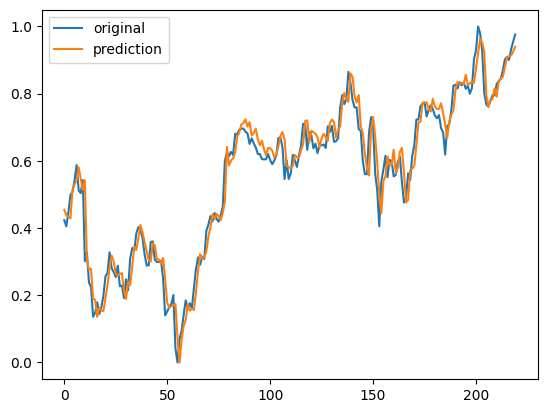

In [72]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

## Seq2Seq
- 이전 은닉층을 현재 입력과 사용해서 바로 $\hat{y}$ 를 추측하는것이 아닌,
- 신경망 학습부분 인코더, $\hat{y}$ 를 예측하는 디코더 부분을 나눠 계산함
- 문자열의 예측이 \<END\> 가 나올떄까지 반복함


- 이를 염두하고 찬찬히 볼것
    - 평문 전처리 과정
    - 단어 임베딩 구조와 단어장 만든 형태
    - 인코더- 디코더 형태
    - 전체적인 행렬 형태
    - 사용된 손실 함수
    



In [91]:
# main reference
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [92]:
import random
import torch
import torch.nn as nn
from torch import optim

In [93]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [94]:
raw = ["I feel hungry.	나는 배가 고프다.",
       "Pytorch is very easy.	파이토치는 매우 쉽다.",
       "Pytorch is a framework for deep learning.	파이토치는 딥러닝을 위한 프레임워크이다.",
       "Pytorch is very clear to use.	파이토치는 사용하기 매우 직관적이다."]

In [95]:
# fix token for "start of sentence" and "end of sentence"
SOS_token = 0
EOS_token = 1

In [96]:
# class for vocabulary related information of data
class Vocab:
    def __init__(self):
        self.vocab2index = {"<SOS>": SOS_token, "<EOS>": EOS_token}
        self.index2vocab = {SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.vocab_count = {}
        self.n_vocab = len(self.vocab2index)

    def add_vocab(self, sentence):
        for word in sentence.split(" "):
            if word not in self.vocab2index:
                self.vocab2index[word] = self.n_vocab
                self.vocab_count[word] = 1
                self.index2vocab[self.n_vocab] = word
                self.n_vocab += 1
            else:
                self.vocab_count[word] += 1

In [97]:
# filter out the long sentence from source and target data
def filter_pair(pair, source_max_length, target_max_length):
    return len(pair[0].split(" ")) < source_max_length and len(pair[1].split(" ")) < target_max_length

In [98]:
# read and preprocess the corpus data
def preprocess(corpus, source_max_length, target_max_length):
    print("reading corpus...")
    pairs = []
    for line in corpus:
        pairs.append([s for s in line.strip().lower().split("\t")])
    print("Read {} sentence pairs".format(len(pairs)))

    pairs = [pair for pair in pairs if filter_pair(pair, source_max_length, target_max_length)]
    print("Trimmed to {} sentence pairs".format(len(pairs)))

    source_vocab = Vocab()
    target_vocab = Vocab()

    print("Counting words...")
    for pair in pairs:
        source_vocab.add_vocab(pair[0])
        target_vocab.add_vocab(pair[1])
    print("source vocab size =", source_vocab.n_vocab)
    print("target vocab size =", target_vocab.n_vocab)

    return pairs, source_vocab, target_vocab

In [99]:
# declare simple encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        return x, hidden

In [100]:
# declare simple decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        x = self.softmax(self.out(x[0]))
        return x, hidden

In [101]:
# convert sentence to the index tensor
def tensorize(vocab, sentence):
    indexes = [vocab.vocab2index[word] for word in sentence.split(" ")]
    indexes.append(vocab.vocab2index["<EOS>"])
    return torch.Tensor(indexes).long().to(device).view(-1, 1)

In [102]:
# training seq2seq
def train(pairs, source_vocab, target_vocab, encoder, decoder, n_iter, print_every=1000, learning_rate=0.01):
    loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_batch = [random.choice(pairs) for _ in range(n_iter)]
    training_source = [tensorize(source_vocab, pair[0]) for pair in training_batch]
    training_target = [tensorize(target_vocab, pair[1]) for pair in training_batch]

    criterion = nn.NLLLoss()

    for i in range(1, n_iter + 1):
        source_tensor = training_source[i - 1]
        target_tensor = training_target[i - 1]

        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        source_length = source_tensor.size(0)
        target_length = target_tensor.size(0)

        loss = 0

        for enc_input in range(source_length):
            _, encoder_hidden = encoder(source_tensor[enc_input], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]]).long().to(device)
        decoder_hidden = encoder_hidden # connect encoder output to decoder input

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # teacher forcing

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        loss_iter = loss.item() / target_length
        loss_total += loss_iter

        if i % print_every == 0:
            loss_avg = loss_total / print_every
            loss_total = 0
            print("[{} - {}%] loss = {:05.4f}".format(i, i / n_iter * 100, loss_avg))

In [112]:
# insert given sentence to check the training
def evaluate(pairs, source_vocab, target_vocab, encoder, decoder, target_max_length):
    for pair in pairs:
        print(">", pair[0])
        print("=", pair[1])
        source_tensor = tensorize(source_vocab, pair[0])
        source_length = source_tensor.size()[0]
        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        for ei in range(source_length):
            _, encoder_hidden = encoder(source_tensor[ei], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]]).long().to(device)
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(target_max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top_index = decoder_output.data.topk(1)
            if top_index.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(target_vocab.index2vocab[top_index.item()])

            decoder_input = top_index.squeeze().detach()

        predict_words = decoded_words
        predict_sentence = " ".join(predict_words)
        print("<", predict_sentence)
        print("")

In [104]:
# declare max length for sentence
SOURCE_MAX_LENGTH = 10
TARGET_MAX_LENGTH = 12

In [105]:
# preprocess the corpus
load_pairs, load_source_vocab, load_target_vocab = preprocess(raw, SOURCE_MAX_LENGTH, TARGET_MAX_LENGTH)
print(random.choice(load_pairs))

reading corpus...
Read 4 sentence pairs
Trimmed to 4 sentence pairs
Counting words...
source vocab size = 17
target vocab size = 13
['i feel hungry.', '나는 배가 고프다.']


In [106]:
# declare the encoder and the decoder
enc_hidden_size = 16
dec_hidden_size = enc_hidden_size
enc = Encoder(load_source_vocab.n_vocab, enc_hidden_size).to(device)
dec = Decoder(dec_hidden_size, load_target_vocab.n_vocab).to(device)

In [107]:
# train seq2seq model
train(load_pairs, load_source_vocab, load_target_vocab, enc, dec, 5000, print_every=1000)

[1000 - 20.0%] loss = 0.7422
[2000 - 40.0%] loss = 0.1074
[3000 - 60.0%] loss = 0.0332
[4000 - 80.0%] loss = 0.0184
[5000 - 100.0%] loss = 0.0126


In [113]:
# check the model with given data
evaluate(load_pairs, load_source_vocab, load_target_vocab, enc, dec, TARGET_MAX_LENGTH)

> i feel hungry.
= 나는 배가 고프다.
< 나는 배가 고프다. <EOS>

> pytorch is very easy.
= 파이토치는 매우 쉽다.
< 파이토치는 매우 쉽다. <EOS>

> pytorch is a framework for deep learning.
= 파이토치는 딥러닝을 위한 프레임워크이다.
< 파이토치는 딥러닝을 위한 프레임워크이다. <EOS>

> pytorch is very clear to use.
= 파이토치는 사용하기 매우 직관적이다.
< 파이토치는 사용하기 매우 직관적이다. <EOS>

